In [1]:
import re
from typing import Dict, List, Optional, Text, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, Add, Activation, UpSampling2D, ReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from sklearn.metrics import precision_recall_curve, auc


2024-12-13 20:32:08.237714: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-13 20:32:08.289390: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-13 20:32:08.289436: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-13 20:32:08.290813: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-13 20:32:08.299449: I tensorflow/core/platform/cpu_feature_guar

### Load TensorFlow Binary Files
Source: https://github.com/google-research/google-research/blob/master/simulation_research/next_day_wildfire_spread/   
F. Huot, R. L. Hu, N. Goyal, T. Sankar, M. Ihme, and Y.-F. Chen, “Next Day Wildfire Spread: A Machine Learning Data Set to Predict Wildfire Spreading from Remote-Sensing Data”, arXiv preprint, 2021.

In [2]:
train_file_pattern = 'next-day-wildfire-spread/versions/2/next_day_wildfire_spread_train*'
eval_file_pattern = 'next-day-wildfire-spread/versions/2/next_day_wildfire_spread_eval*'
test_file_pattern = 'next-day-wildfire-spread/versions/2/next_day_wildfire_spread_test*'

In [3]:
# Constants for the data reader

INPUT_FEATURES = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph',
                  'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']

OUTPUT_FEATURES = ['FireMask', ]

# Data statistics
# For each variable, the statistics are ordered in the form:
# (min_clip, max_clip, mean, std)
DATA_STATS = {
    # 0.1 percentile, 99.9 percentile
    'elevation': (0.0, 3141.0, 657.3003, 649.0147),
    # Pressure
    # 0.1 percentile, 99.9 percentile
    'pdsi': (-6.1298, 7.8760, -0.0053, 2.6823),
    'NDVI': (-9821.0, 9996.0, 5157.625, 2466.6677),
    # Precipitation in mm.
    # Negative values make no sense, so min is set to 0.
    # 0., 99.9 percentile
    'pr': (0.0, 44.5304, 1.7398051, 4.4828),
    # Specific humidity ranges from 0 to 100%.
    'sph': (0., 1., 0.0071658953, 0.0042835088),
    # Wind direction in degrees clockwise from north.
    # Thus min set to 0 and max set to 360.
    'th': (0., 360.0, 190.3298, 72.5985),
    # Min/max temperature in Kelvin.
    # -20 degree C, 99.9 percentile
    'tmmn': (253.15, 298.9489, 281.08768, 8.9824),
    # -20 degree C, 99.9 percentile
    'tmmx': (253.15, 315.0923, 295.17383, 9.8155),
    # Wind speed.
    # Negative values do not make sense, given there is a wind direction.
    # 0., 99.9 percentile
    'vs': (0.0, 10.0243, 3.8501, 1.4110),
    # NFDRS fire danger index energy release component expressed in BTU's per
    # square foot.
    # Negative values do not make sense. Thus min set to zero.
    # 0., 99.9 percentile
    'erc': (0.0, 106.2489, 37.3263, 20.8460),
    # Population
    # min, 99.9 percentile
    'population': (0., 2534.0630, 25.5314, 154.7233),
    # We don't want to normalize the FireMasks.
    'PrevFireMask': (-1., 1., 0., 1.),
    'FireMask': (-1., 1., 0., 1.)
}

In [4]:
"""Library of common functions used in deep learning neural networks.
"""
def random_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
    num_in_channels: int,
    num_out_channels: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Randomly axis-align crop input and output image tensors.

  Args:
    input_img: Tensor with dimensions HWC.
    output_img: Tensor with dimensions HWC.
    sample_size: Side length (square) to crop to.
    num_in_channels: Number of channels in `input_img`.
    num_out_channels: Number of channels in `output_img`.
  Returns:
    input_img: Tensor with dimensions HWC.
    output_img: Tensor with dimensions HWC.
  """
  combined = tf.concat([input_img, output_img], axis=2)
  combined = tf.image.random_crop(
      combined,
      [sample_size, sample_size, num_in_channels + num_out_channels])
  input_img = combined[:, :, 0:num_in_channels]
  output_img = combined[:, :, -num_out_channels:]
  return input_img, output_img


def center_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Calls `tf.image.central_crop` on input and output image tensors.

  Args:
    input_img: Tensor with dimensions HWC.
    output_img: Tensor with dimensions HWC.
    sample_size: Side length (square) to crop to.
  Returns:
    input_img: Tensor with dimensions HWC.
    output_img: Tensor with dimensions HWC.
  """
  central_fraction = sample_size / input_img.shape[0]
  input_img = tf.image.central_crop(input_img, central_fraction)
  output_img = tf.image.central_crop(output_img, central_fraction)
  return input_img, output_img


In [5]:
"""Dataset reader for Earth Engine data."""

def _get_base_key(key: Text) -> Text:
  """Extracts the base key from the provided key.

  Earth Engine exports TFRecords containing each data variable with its
  corresponding variable name. In the case of time sequences, the name of the
  data variable is of the form 'variable_1', 'variable_2', ..., 'variable_n',
  where 'variable' is the name of the variable, and n the number of elements
  in the time sequence. Extracting the base key ensures that each step of the
  time sequence goes through the same normalization steps.
  The base key obeys the following naming pattern: '[a-zA-Z]+'
  For instance, for an input key 'variable_1', this function returns 'variable'.
  For an input key 'variable', this function simply returns 'variable'.

  Args:
    key: Input key.

  Returns:
    The corresponding base key.

  Raises:
    ValueError when `key` does not match the expected pattern.
  """
  match = re.match(r'[a-zA-Z]+', key)
  if match:
    return match.group(1)
  raise ValueError(
      f'The provided key does not match the expected pattern: {key}')


def _clip_and_rescale(inputs: tf.Tensor, key: Text) -> tf.Tensor:
  """Clips and rescales inputs with the stats corresponding to `key`.

  Args:
    inputs: Inputs to clip and rescale.
    key: Key describing the inputs.

  Returns:
    Clipped and rescaled input.

  Raises:
    ValueError if there are no data statistics available for `key`.
  """
  base_key = _get_base_key(key)
  if base_key not in DATA_STATS:
    raise ValueError(
        'No data statistics available for the requested key: {}.'.format(key))
  min_val, max_val, _, _ = DATA_STATS[base_key]
  inputs = tf.clip_by_value(inputs, min_val, max_val)
  return tf.math.divide_no_nan((inputs - min_val), (max_val - min_val))


def _clip_and_normalize(inputs: tf.Tensor, key: Text) -> tf.Tensor:
  """Clips and normalizes inputs with the stats corresponding to `key`.

  Args:
    inputs: Inputs to clip and normalize.
    key: Key describing the inputs.

  Returns:
    Clipped and normalized input.

  Raises:
    ValueError if there are no data statistics available for `key`.
  """
  base_key = _get_base_key(key)
  if base_key not in DATA_STATS:
    raise ValueError(
        'No data statistics available for the requested key: {}.'.format(key))
  min_val, max_val, mean, std = DATA_STATS[base_key]
  inputs = tf.clip_by_value(inputs, min_val, max_val)
  inputs = inputs - mean
  return tf.math.divide_no_nan(inputs, std)

def _get_features_dict(
    sample_size: int,
    features: List[Text],
) -> Dict[Text, tf.io.FixedLenFeature]:
  """Creates a features dictionary for TensorFlow IO.

  Args:
    sample_size: Size of the input tiles (square).
    features: List of feature names.

  Returns:
    A features dictionary for TensorFlow IO.
  """
  sample_shape = [sample_size, sample_size]
  features = set(features)
  columns = [
      tf.io.FixedLenFeature(shape=sample_shape, dtype=tf.float32)
      for _ in features
  ]
  return dict(zip(features, columns))



def _parse_fn(
    example_proto: tf.train.Example, data_size: int, sample_size: int,
    num_in_channels: int, clip_and_normalize: bool,
    clip_and_rescale: bool, random_crop: bool, center_crop: bool,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Reads a serialized example.

  Args:
    example_proto: A TensorFlow example protobuf.
    data_size: Size of tiles (square) as read from input files.
    sample_size: Size the tiles (square) when input into the model.
    num_in_channels: Number of input channels.
    clip_and_normalize: True if the data should be clipped and normalized.
    clip_and_rescale: True if the data should be clipped and rescaled.
    random_crop: True if the data should be randomly cropped.
    center_crop: True if the data should be cropped in the center.

  Returns:
    (input_img, output_img) tuple of inputs and outputs to the ML model.
  """
  if (random_crop and center_crop):
    raise ValueError('Cannot have both random_crop and center_crop be True')
  input_features, output_features = INPUT_FEATURES, OUTPUT_FEATURES
  feature_names = input_features + output_features
  features_dict = _get_features_dict(data_size, feature_names)
  features = tf.io.parse_single_example(example_proto, features_dict)

  if clip_and_normalize:
    inputs_list = [
        _clip_and_normalize(features.get(key), key) for key in input_features
    ]
  elif clip_and_rescale:
    inputs_list = [
        _clip_and_rescale(features.get(key), key) for key in input_features
    ]
  else:
    inputs_list = [features.get(key) for key in input_features]

  inputs_stacked = tf.stack(inputs_list, axis=0)
  input_img = tf.transpose(inputs_stacked, [1, 2, 0])

  outputs_list = [features.get(key) for key in output_features]
  assert outputs_list, 'outputs_list should not be empty'
  outputs_stacked = tf.stack(outputs_list, axis=0)

  outputs_stacked_shape = outputs_stacked.get_shape().as_list()
  assert len(outputs_stacked.shape) == 3, ('outputs_stacked should be rank 3'
                                            'but dimensions of outputs_stacked'
                                            f' are {outputs_stacked_shape}')
  output_img = tf.transpose(outputs_stacked, [1, 2, 0])

  if random_crop:
    input_img, output_img = random_crop_input_and_output_images(
        input_img, output_img, sample_size, num_in_channels, 1)
  if center_crop:
    input_img, output_img = center_crop_input_and_output_images(
        input_img, output_img, sample_size)
  return input_img, output_img


def get_dataset(file_pattern: Text, data_size: int, sample_size: int,
                batch_size: int, num_in_channels: int, compression_type: Text,
                clip_and_normalize: bool, clip_and_rescale: bool,
                random_crop: bool, center_crop: bool) -> tf.data.Dataset:
  """Gets the dataset from the file pattern.

  Args:
    file_pattern: Input file pattern.
    data_size: Size of tiles (square) as read from input files.
    sample_size: Size the tiles (square) when input into the model.
    batch_size: Batch size.
    num_in_channels: Number of input channels.
    compression_type: Type of compression used for the input files.
    clip_and_normalize: True if the data should be clipped and normalized, False
      otherwise.
    clip_and_rescale: True if the data should be clipped and rescaled, False
      otherwise.
    random_crop: True if the data should be randomly cropped.
    center_crop: True if the data shoulde be cropped in the center.

  Returns:
    A TensorFlow dataset loaded from the input file pattern, with features
    described in the constants, and with the shapes determined from the input
    parameters to this function.
  """
  if (clip_and_normalize and clip_and_rescale):
    raise ValueError('Cannot have both normalize and rescale.')
  dataset = tf.data.Dataset.list_files(file_pattern)
  dataset = dataset.interleave(
      lambda x: tf.data.TFRecordDataset(x, compression_type=compression_type),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  dataset = dataset.map(
      lambda x: _parse_fn(  # pylint: disable=g-long-lambda
          x, data_size, sample_size, num_in_channels, clip_and_normalize,
          clip_and_rescale, random_crop, center_crop),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

In [6]:
train_data = get_dataset(
      train_file_pattern,
      data_size=64,
      sample_size=32,
      batch_size=100,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

eval_data = get_dataset(
      eval_file_pattern,
      data_size=64,
      sample_size=32,
      batch_size=100,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

test_data = get_dataset(
      test_file_pattern,
      data_size=64,
      sample_size=32,
      batch_size=100,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

2024-12-13 20:32:12.158098: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9620 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:60:00.0, compute capability: 7.5


In [7]:
def extract_all_data(dataset):
    inputs, labels = [], []
    for input_batch, label_batch in dataset:
        inputs.append(input_batch)
        labels.append(label_batch)
    return tf.concat(inputs, axis=0), tf.concat(labels, axis=0)

In [8]:
train_inputs, train_labels = extract_all_data(train_data)
eval_inputs, eval_labels = extract_all_data(eval_data)
test_inputs, test_labels = extract_all_data(test_data)

In [9]:
train_inputs.shape, eval_inputs.shape, test_inputs.shape

(TensorShape([14979, 32, 32, 12]),
 TensorShape([1877, 32, 32, 12]),
 TensorShape([1689, 32, 32, 12]))

### Plotting

In [10]:
TITLES = [
  'Elevation',
  'Wind\ndirection',
  'Wind\nvelocity',
  'Min\ntemp',
  'Max\ntemp',
  'Humidity',
  'Precip',
  'Drought',
  'Vegetation',
  'Population\ndensity',
  'Energy\nrelease\ncomponent',
  'Previous\nfire\nmask',
  'Fire\nmask'
]

In [11]:
n_rows = 5
n_features = train_inputs.shape[3]
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)
keys = INPUT_FEATURES

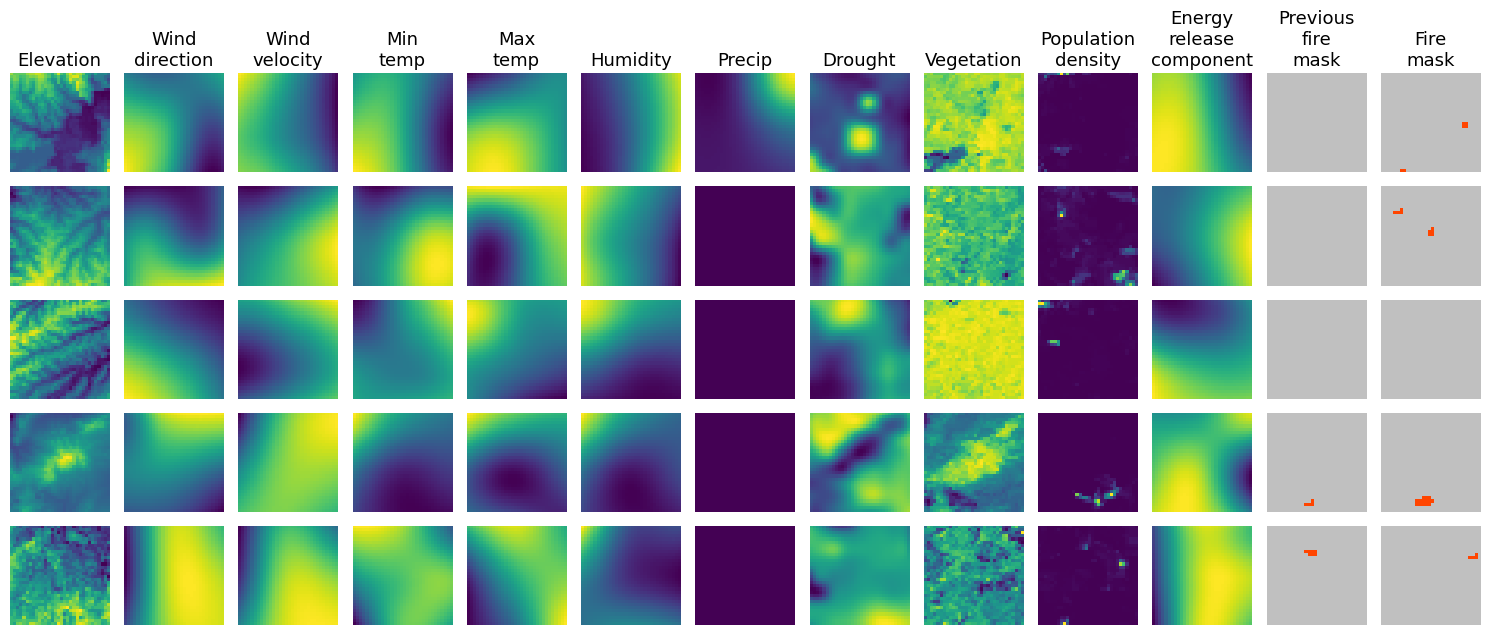

In [12]:
fig = plt.figure(figsize=(15,6.5))

for i in range(n_rows):
  for j in range(n_features + 1):
    ax = plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
    if i == 0:
      img = plt.title(TITLES[j], fontsize=13)
    if j < n_features - 1:
      img = plt.imshow(train_inputs[i, :, :, j], cmap='viridis')
    if j == n_features - 1:
      img = plt.imshow(train_inputs[i, :, :, -1], cmap=CMAP, norm=NORM)
    if j == n_features:
      img = plt.imshow(train_labels[i, :, :, 0], cmap=CMAP, norm=NORM) 
    plt.axis('off')
plt.tight_layout()

In [13]:
train_inputs_aggregated = np.mean(train_inputs.numpy(), axis=(1, 2)) # avg over height and width
train_labels_aggregated = np.mean(train_labels.numpy(), axis=(1, 2))
train_data_aggregated = np.concatenate([train_inputs_aggregated, train_labels_aggregated], axis=1)

In [14]:
input_feature_names = [f"{feature}" for feature in keys]
label_feature_names = [f"Fire mask"]
columns = TITLES

agg_train_df = pd.DataFrame(train_data_aggregated, columns=columns)

In [15]:
agg_train_df['Fire\nGrowth'] = agg_train_df['Fire\nmask'] - agg_train_df['Previous\nfire\nmask']

In [16]:
correlation_matrix = agg_train_df.corr()

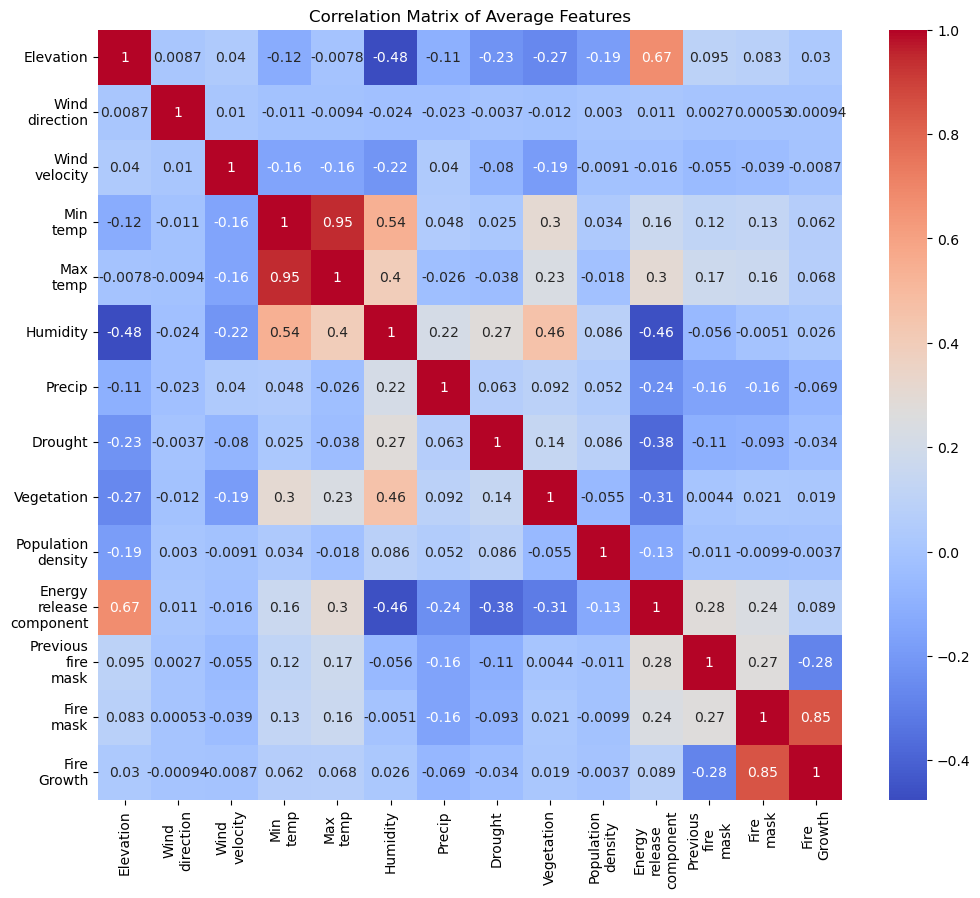

In [17]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=True)
plt.title("Correlation Matrix of Average Features")
plt.show()

ERC is a calculated output of the National
Fire Danger Rating System (NFDRS). It is considered a
composite fuel moisture index as it reflects the contribution
of all fuels to potential fire intensity

### Note: the notebok quickly devolves into chaos below

In [18]:
UNITS = [
    'm', 
    'degrees',
    'm/s',
    'K',
    'K',
    'kg/kg',
    'mm,\ndaily total',
    'index',
    'index',
    'people\nper km$^2$',
    'index',
]

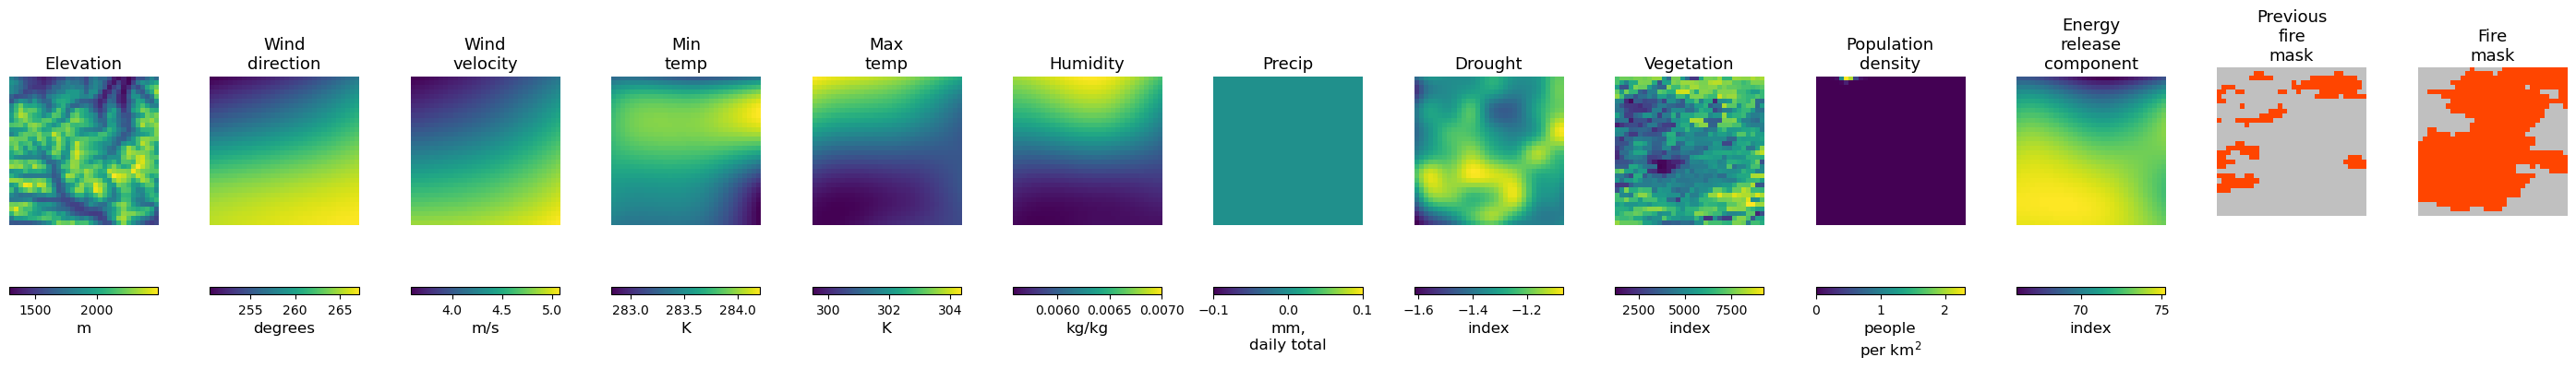

In [26]:
i = 5755 # Index of the row to display

fig, axes = plt.subplots(1, n_features + 1, figsize=(28, 5))  # One row of subplots

for j in range(n_features + 1):
    ax = axes[j]  # Access each subplot
    ax.axis('off')  # Turn off axes
    ax.set_title(TITLES[j], fontsize=13)
    if j < n_features - 1:
        img = ax.imshow(train_inputs_filtered[i, :, :, j], cmap='viridis')  # Show input features
        cbar = plt.colorbar(img, orientation='horizontal')
        cbar.set_label(UNITS[j], fontsize=12)
    elif j == n_features - 1:
        img = ax.imshow(train_inputs_filtered[i, :, :, -1], cmap=CMAP, norm=NORM)  # Special feature
    else:
        img = ax.imshow(train_labels_filtered[i, :, :, 0], cmap=CMAP, norm=NORM)  # Show label
plt.tight_layout()
plt.show()

In [20]:
# Apply the mask to filter out invalid samples
# Mask for inputs: Exclude if any value in train_inputs is -1 across the last two dimensions
train_input_mask = tf.reduce_all(train_inputs[..., -1] != -1, axis=(1, 2))
train_label_mask = tf.reduce_all(train_labels[..., -1] != -1, axis=(1, 2))
train_mask = tf.logical_and(train_input_mask, train_label_mask)
train_inputs_filtered = tf.boolean_mask(train_inputs, train_mask)
train_labels_filtered = tf.boolean_mask(train_labels, train_mask)

# For evaluation inputs
eval_input_mask = tf.reduce_all(eval_inputs[..., -1] != -1, axis=(1, 2))
eval_label_mask = tf.reduce_all(eval_labels[..., -1] != -1, axis=(1, 2))
eval_mask = tf.logical_and(eval_input_mask, eval_label_mask)
eval_inputs_filtered = tf.boolean_mask(eval_inputs, eval_mask)
eval_labels_filtered = tf.boolean_mask(eval_labels, eval_mask)

# For test inputs
test_input_mask = tf.reduce_all(test_inputs[..., -1] != -1, axis=(1, 2))
test_label_mask = tf.reduce_all(test_labels[..., -1] != -1, axis=(1, 2))
test_mask = tf.logical_and(test_input_mask, test_label_mask)
test_inputs_filtered = tf.boolean_mask(test_inputs, test_mask)
test_labels_filtered = tf.boolean_mask(test_labels, test_mask)

In [21]:
train_labels_filtered.shape

TensorShape([10830, 32, 32, 1])

In [22]:
prev_fire_area = np.sum(np.where(train_inputs_filtered[..., -1].numpy() < 0, 0, train_inputs_filtered[..., -1].numpy()), axis=(1, 2))
cur_fire_area = np.squeeze(
    np.sum(np.where(train_labels_filtered.numpy() < 0, 0, train_labels_filtered.numpy()), axis=(1, 2), keepdims=False)
)

In [23]:
fire_growth_area = cur_fire_area - prev_fire_area

In [24]:
fire_growth_area.argmax()

5755

In [319]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [320]:
n_samples, height, width, n_channels = train_inputs.shape
n_labels = train_labels.shape[3]

In [428]:
X_train = train_inputs_filtered.numpy().reshape((-1, n_channels)) # Shape (n_samples * height * width, n_channels)
y_train = train_labels_filtered.numpy().reshape((-1, n_labels)) # Shape (n_samples * height * width, 1)
y_train = y_train.ravel()

X_eval = eval_inputs_filtered.numpy().reshape((-1, n_channels))
y_eval = eval_labels_filtered.numpy().reshape((-1, n_labels))
y_eval = y_eval.ravel()

X_test = test_inputs_filtered.numpy().reshape((-1, n_channels))
y_test = test_labels_filtered.numpy().reshape((-1, n_labels))
y_test = y_test.ravel()

damping_factor = 0.45
X_train[:, -1] *= damping_factor  # Apply to "previous fire mask"
X_test[:, -1] *= damping_factor


In [429]:
from sklearn.utils import resample

class_0 = X_train[y_train == 0]
class_1 = X_train[y_train == 1]

# Downsample majority class
class_0_downsampled, y_0_downsampled = resample(
    class_0, y_train[y_train == 0],
    replace=False,  # Without replacement
    n_samples=len(class_1),  # Match the minority class size
    random_state=42
)

# Combine balanced data
X_train_balanced = np.vstack((class_0_downsampled, class_1))
y_train_balanced = np.hstack((y_0_downsampled, y_train[y_train == 1]))

In [ ]:
from sklearn.metrics import precision_recall_curve, auc

best_w = None
best_pr_auc = 0

for W in range(1, 9):  # Search W values from 1 to 8
    class_weight = {
        0: 1,
        1: n_total / n_no_fire * W,
    }
    
    # Logistic regression example
    log_reg = LogisticRegression(max_iter=1000, verbose=0, class_weight=class_weight)
    log_reg.fit(X_train_balanced, y_train_balanced)
    
    # Evaluate
    y_eval_pred = log_reg.predict_proba(X_eval)[:, 1]
    precision, recall, _ = precision_recall_curve(y_eval, y_eval_pred)
    pr_auc = auc(recall, precision)
    
    if pr_auc > best_pr_auc:
        best_pr_auc = pr_auc
        best_w = W

print(f"Best W: {best_w} with AUC-PR: {best_pr_auc}")

In [438]:
W = 6
n_total = len(y_train_balanced)
n_no_fire = (y_train_balanced == 0).sum()
class_weight = {
    0: n_total / n_no_fire * W ,  # "No fire" class
    1: 1 # "Fire" class
}

In [439]:
log_reg = LogisticRegression(max_iter=500, verbose=1, class_weight=class_weight, penalty='l2', C=0.001)  # Smaller C increases regularization strength)
log_reg.fit(X_train_balanced, y_train_balanced)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  2.32183D+03


 This problem is unconstrained.



At iterate   50    f=  2.57323D-01    |proj g|=  2.23574D-01

At iterate  100    f=  2.56093D-01    |proj g|=  7.74949D+00

At iterate  150    f=  2.49871D-01    |proj g|=  1.90394D-01

At iterate  200    f=  2.37313D-01    |proj g|=  3.26429D+01

At iterate  250    f=  2.32667D-01    |proj g|=  3.77570D-02

At iterate  300    f=  2.32583D-01    |proj g|=  1.64135D+00

At iterate  350    f=  2.32434D-01    |proj g|=  1.27363D+00

At iterate  400    f=  2.32325D-01    |proj g|=  5.20944D-03

At iterate  450    f=  2.32314D-01    |proj g|=  5.07754D-02

At iterate  500    f=  2.32283D-01    |proj g|=  3.10162D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.001, class_weight={0: 12.0, 1: 1}, max_iter=500,
                   verbose=1)

In [440]:
y_pred = log_reg.predict(X_test)
y_pred_img = y_pred.reshape((test_inputs_filtered.shape[0], height, width, n_labels))

In [441]:
feature_weights = log_reg.coef_[0]
print(f"Feature weights: {feature_weights}")


Feature weights: [ 7.15538166e-05  1.52685356e-05 -1.28082971e-02  2.98329740e-02
 -3.92768312e-02  1.41281139e-02 -9.75150529e-01 -4.29122001e-02
 -5.30287694e-06 -1.47446610e-03  2.02084657e-02  5.54421297e+00]


In [442]:
print(classification_report(y_test.flatten(), y_pred.flatten(), digits=4))


              precision    recall  f1-score   support

         0.0     0.9781    0.9912    0.9846   1170950
         1.0     0.4439    0.2406    0.3121     34298

    accuracy                         0.9698   1205248
   macro avg     0.7110    0.6159    0.6483   1205248
weighted avg     0.9629    0.9698    0.9654   1205248



In [38]:
print(classification_report(y_test.flatten(), persitance_labels.flatten(), digits=4))

              precision    recall  f1-score   support

         0.0     0.9794    0.9880    0.9837   1170950
         1.0     0.4166    0.2919    0.3433     34298

    accuracy                         0.9682   1205248
   macro avg     0.6980    0.6399    0.6635   1205248
weighted avg     0.9634    0.9682    0.9655   1205248



In [443]:
precision, recall, _ = precision_recall_curve(y_test, y_pred.flatten())
pr_auc = auc(recall, precision)
print(pr_auc)

0.3530921476679968


In [37]:
persitance_labels = X_test.reshape((test_inputs_filtered.shape[0], height, width, 12))[..., -1]

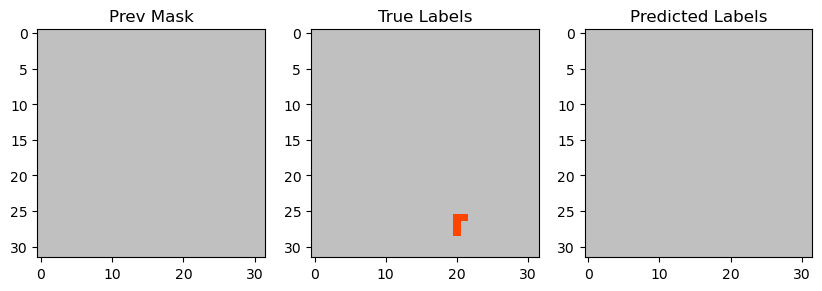

In [435]:
plt.figure(figsize=(10, 5))

i = 632

plt.subplot(1, 3, 1)
plt.imshow(test_inputs_filtered[i, :, :, -1], cmap=CMAP, norm=NORM)  # Assuming single-channel output
plt.title('Prev Mask')

# True labels
plt.subplot(1, 3, 2)
plt.imshow(test_labels_filtered[i, :, :, 0], cmap=CMAP, norm=NORM)  # Assuming single-channel output
plt.title('True Labels')

# Predicted labels
plt.subplot(1, 3, 3)
plt.imshow(y_pred_img[i, :, :, 0], cmap=CMAP, norm=NORM)  # Predicted segmentation mask
plt.title('Predicted Labels')

plt.show()

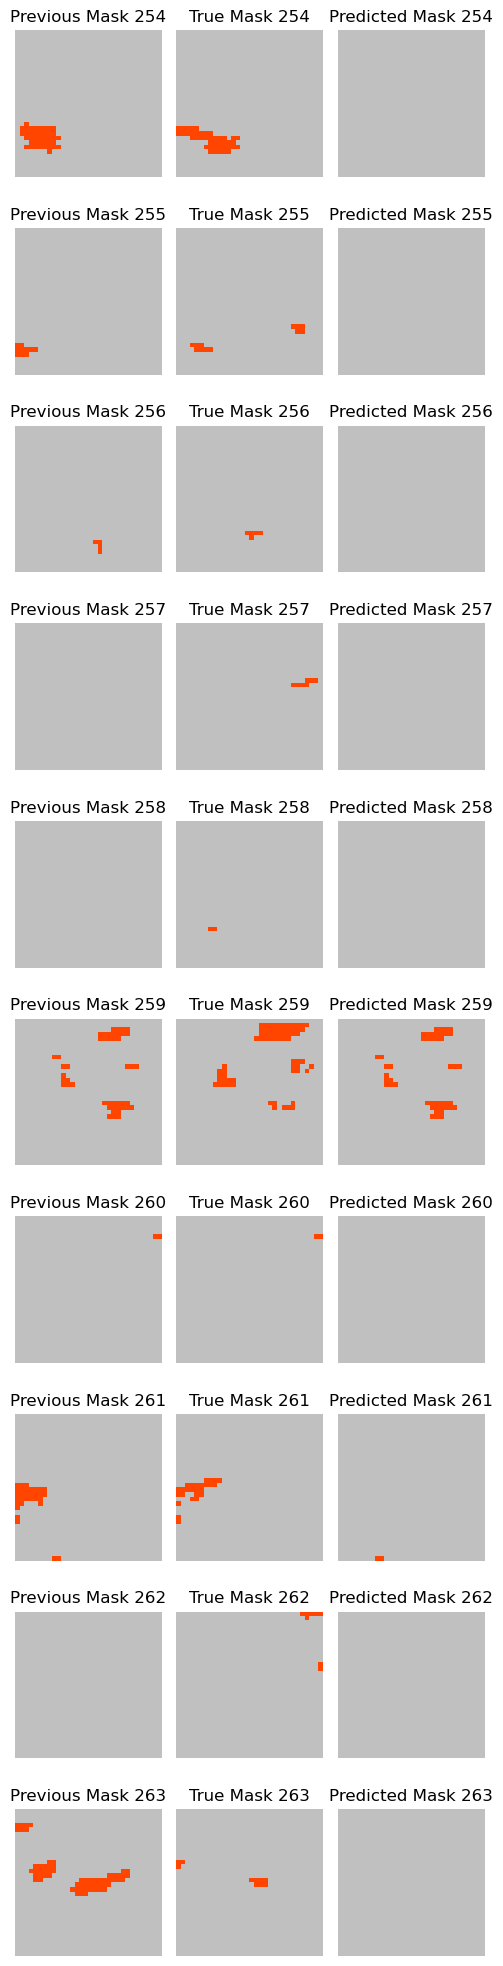

In [437]:
n_samples = 10
n_rows = 10 
n_cols = 1

start_idx = 254  
end_idx = start_idx + n_samples

plt.figure(figsize=(5, 20))

for idx in range(start_idx, end_idx):
    # Plot the previous fire mask
    plt.subplot(n_rows, n_cols * 3, (idx - start_idx) * 3 + 1)
    plt.imshow(test_inputs_filtered[idx, :, :, -1], cmap=CMAP, norm=NORM)
    plt.title(f'Previous Mask {idx}')
    plt.axis('off')  # Hide axis for clarity

    # Plot the true labels
    plt.subplot(n_rows, n_cols * 3, (idx - start_idx) * 3 + 2)
    plt.imshow(test_labels_filtered[idx, :, :, 0], cmap=CMAP, norm=NORM)
    plt.title(f'True Mask {idx}')
    plt.axis('off')

    # Plot the predicted labels
    plt.subplot(n_rows, n_cols * 3, (idx - start_idx) * 3 + 3)
    plt.imshow(y_pred_img[idx, :, :, 0], cmap=CMAP, norm=NORM)
    plt.title(f'Predicted Mask {idx}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# CNNS










In [45]:
def reassemble_data(inputs, labels):
    """
    Reassemble inputs and labels into a TensorFlow dataset.
    """
    return tf.data.Dataset.from_tensor_slices((inputs, labels))

batch_size = 100
# Reassemble datasets
train_data_filtered = reassemble_data(train_inputs_filtered, train_labels_filtered)
train_data_filtered = train_data_filtered.batch(batch_size)

eval_data_filtered = reassemble_data(eval_inputs_filtered, eval_labels_filtered)
eval_data_filtered = eval_data_filtered.batch(batch_size)

test_data_filtered = reassemble_data(test_inputs_filtered, test_labels_filtered)
test_data_filtered = test_data_filtered.batch(batch_size)


In [196]:
from tensorflow.keras import layers, models

def build_cnn_model(input_shape=(32, 32, 12)):
    # Build a CNN model for segmentation
    model = models.Sequential([
        # First convolutional block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2, 2), padding='same'),

        # Second convolutional block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2), padding='same'),

        # Third convolutional block
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2), padding='same'),

        # Upsampling layers to restore the original input size
        layers.Conv2DTranspose(256, (3, 3), activation='relu', padding='same'),
        layers.Conv2DTranspose(256, (3, 3), activation='relu', padding='same'),
        layers.Conv2DTranspose(256, (3, 3), activation='relu', padding='same'),
        layers.UpSampling2D((2, 2)),

        layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same'),
        layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same'),
        layers.UpSampling2D((2, 2)),

        layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same'),
        layers.UpSampling2D((2, 2)),

        # Output layer: Fire mask (1 channel, output shape should be (32, 32, 1))
        layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',  # Binary crossentropy for binary segmentation
                  metrics=['accuracy', tf.keras.metrics.AUC(curve="PR")])
    return model



In [197]:
model = build_cnn_model()


In [198]:
model.fit(train_data_filtered, epochs=10, steps_per_epoch=10)

Epoch 1/10
10/10 [==============================] - 6s 31ms/step - loss: 1.4686 - accuracy: 0.9144 - auc_2: 0.0250
Epoch 2/10
10/10 [==============================] - 0s 30ms/step - loss: 0.1644 - accuracy: 0.9716 - auc_2: 0.0277
Epoch 3/10
10/10 [==============================] - 0s 29ms/step - loss: 0.1452 - accuracy: 0.9724 - auc_2: 0.0301
Epoch 4/10
10/10 [==============================] - 0s 29ms/step - loss: 0.1438 - accuracy: 0.9720 - auc_2: 0.0330
Epoch 5/10
10/10 [==============================] - 0s 28ms/step - loss: 0.1354 - accuracy: 0.9717 - auc_2: 0.0332
Epoch 6/10
10/10 [==============================] - 0s 29ms/step - loss: 0.1289 - accuracy: 0.9731 - auc_2: 0.0314
Epoch 7/10
10/10 [==============================] - 0s 29ms/step - loss: 0.1403 - accuracy: 0.9704 - auc_2: 0.0347
Epoch 8/10
10/10 [==============================] - 0s 27ms/step - loss: 0.1205 - accuracy: 0.9751 - auc_2: 0.0315
Epoch 9/10
10/10 [==============================] - 0s 28ms/step - loss: 0.1214 

In [199]:
model.save('cnn_model')

INFO:tensorflow:Assets written to: cnn_model/assets


INFO:tensorflow:Assets written to: cnn_model/assets


In [200]:
eval_loss, eval_accuracy, eval_auc = model.evaluate(eval_data_filtered)
print(f'Eval Loss: {eval_loss}, Eval Accuracy: {eval_accuracy}, Eval AUC: {eval_auc}')

14/14 [==============================] - 1s 14ms/step - loss: 0.1408 - accuracy: 0.9665 - auc_2: 0.0644
Eval Loss: 0.14083103835582733, Eval Accuracy: 0.9664682745933533, Eval AUC: 0.06444794684648514


In [201]:
predictions = model.predict(test_data_filtered)

12/12 [==============================] - 0s 9ms/step


In [227]:
auc_pr = tf.keras.metrics.AUC(curve='PR')
auc_pr.update_state(test_labels_filtered, predictions_tensor)
print(f"AUC-PR: {auc_pr.result().numpy()}")

AUC-PR: 0.03358898311853409


In [228]:
accuracy = tf.keras.metrics.Accuracy()
accuracy.update_state(test_labels_filtered, predictions_tensor)  # Round predictions for binary accuracy
print(f"Accuracy: {accuracy.result().numpy()}")

Accuracy: 0.8189982771873474


In [229]:
recall = tf.keras.metrics.Recall()
recall.update_state(test_labels_filtered, predictions_tensor)
print(f"Recall: {recall.result().numpy()}")

Recall: 0.23858533799648285


In [230]:
precision = tf.keras.metrics.Precision()
precision.update_state(test_labels_filtered, predictions_tensor)
print(f"Precision: {precision.result().numpy()}")

Precision: 0.04087004438042641


In [186]:
persistance = tf.expand_dims(test_inputs_filtered[..., -1], axis=-1)

In [313]:
thresholded = (predictions > 0.067).astype(float)
predictions_tensor = tf.convert_to_tensor(thresholded)
print(predictions_tensor[423, :, :, 0])

tf.Tensor(
[[1. 1. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 0. ... 1. 1. 1.]
 [1. 1. 0. ... 1. 1. 1.]], shape=(32, 32), dtype=float64)


In [314]:
test_labels_filtered = tf.cast(test_labels_filtered, tf.float32)    # Ensure labels are also float32
predictions_tensor = tf.cast(predictions_tensor, tf.float32)    # Ensure labels are also float32

accuracies = np.mean(predictions_tensor == test_labels_filtered, axis=(1, 2, 3))  # Mean accuracy per sample

filtered_accuracies = tf.boolean_mask(accuracies, accuracies < 1.0)

# Get the indices of the filtered accuracies
filtered_indices = tf.where(accuracies < .80)[:, 0]

# Get the indices of the top n accuracies from the filtered ones
n = 5  # Number of top samples
top_n_filtered_indices = tf.gather(filtered_indices, tf.argsort(filtered_accuracies, direction='DESCENDING')[:n])

# Print top filtered accuracies and their indices
print("Top n samples with highest accuracy below 1:")
for rank, idx in enumerate(top_n_filtered_indices.numpy()):
    print(f"Rank {rank + 1}: Index {idx}, Accuracy: {accuracies[idx]:.4f}")


Top n samples with highest accuracy below 1:
Rank 1: Index 219, Accuracy: 0.7695
Rank 2: Index 877, Accuracy: 0.1934
Rank 3: Index 924, Accuracy: 0.4375
Rank 4: Index 0, Accuracy: 0.9883
Rank 5: Index 0, Accuracy: 0.9883


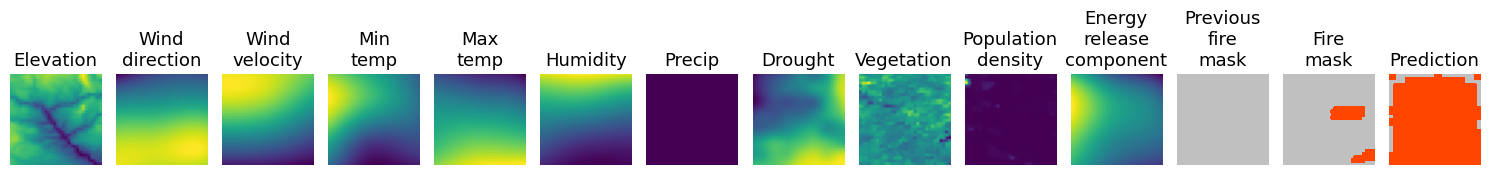

In [318]:
i = 877     # Index of the row to display

fig, axes = plt.subplots(1, n_features + 2, figsize=(15, 3))  # One row of subplots

for j in range(n_features + 2):
    ax = axes[j]  # Access each subplot
    ax.axis('off')  # Turn off axes
    if j < n_features - 1:
        ax.set_title(TITLES[j], fontsize=13)
        img = ax.imshow(test_inputs_filtered[i, :, :, j], cmap='viridis')  # Show input features
    elif j == n_features - 1:
        ax.set_title(TITLES[j], fontsize=13)
        img = ax.imshow(test_inputs_filtered[i, :, :, -1], cmap=CMAP, norm=NORM)  # Special feature
    elif j == n_features:
        ax.set_title(TITLES[j], fontsize=13)
        img = ax.imshow(test_labels_filtered[i, :, :, 0], cmap=CMAP, norm=NORM)  # Show label
    else:
        ax.set_title("Prediction", fontsize=13)
        img = ax.imshow(predictions_tensor[i, :, :, 0], cmap=CMAP, norm=NORM)
plt.tight_layout()
plt.show()

In [185]:
test_inputs.shape

TensorShape([1689, 32, 32, 12])

In [145]:
predictions_tensor.shape

TensorShape([1176, 32, 32, 1])

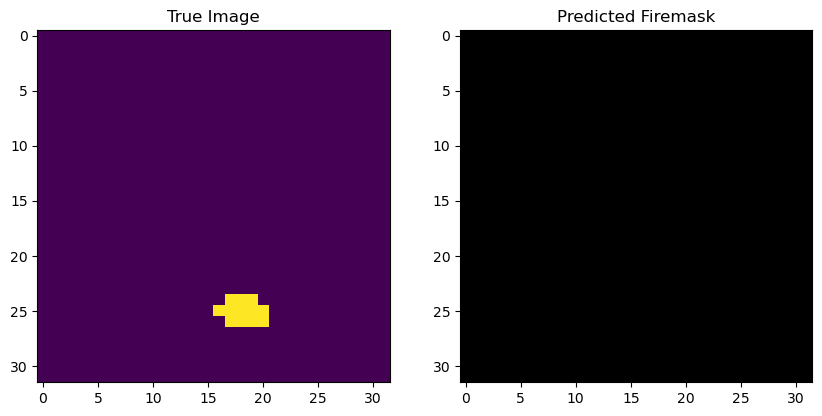

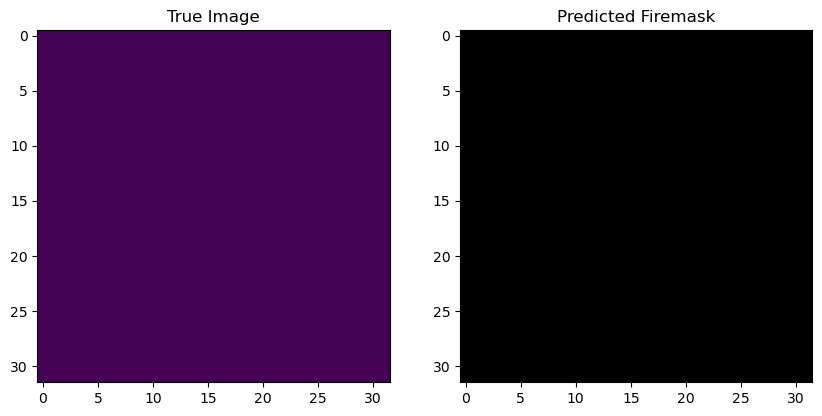

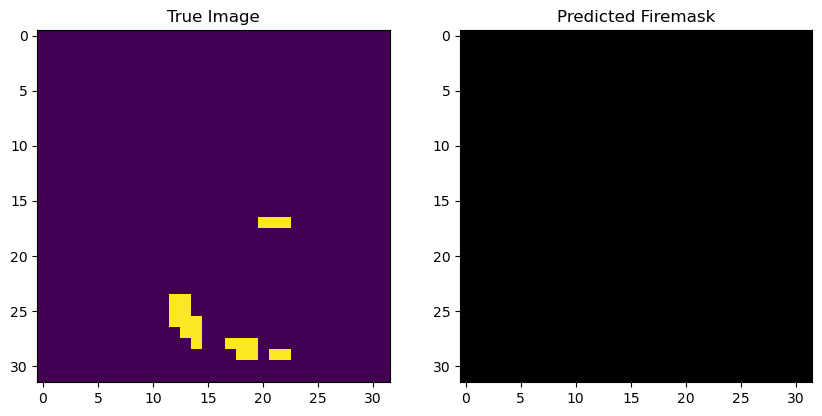

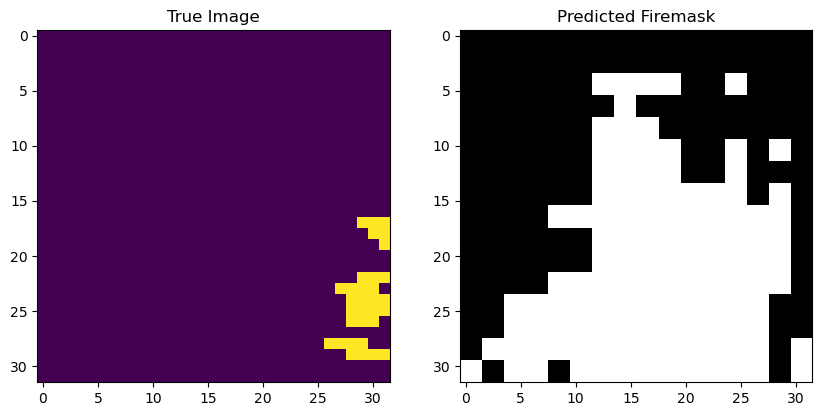

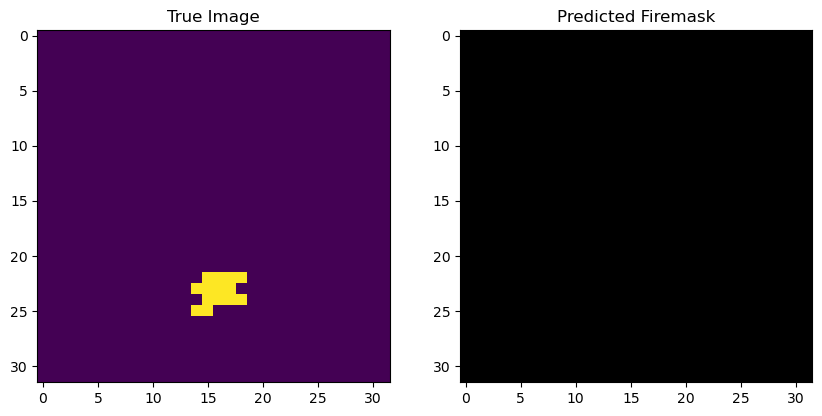

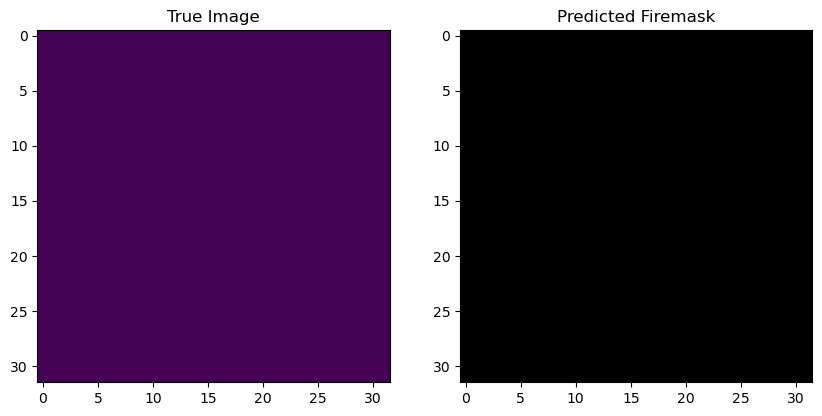

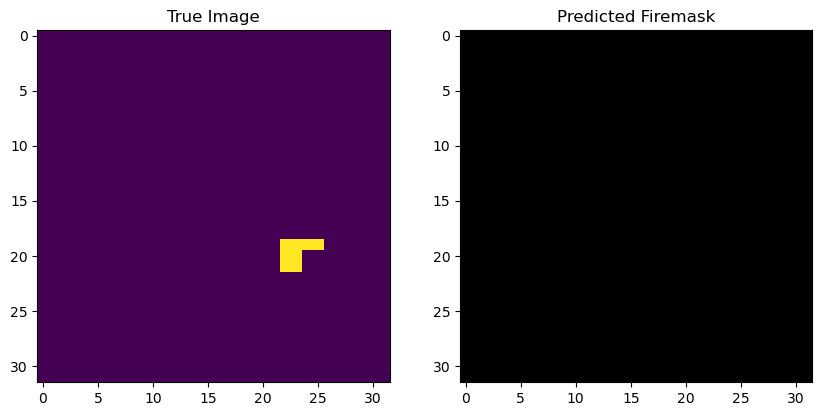

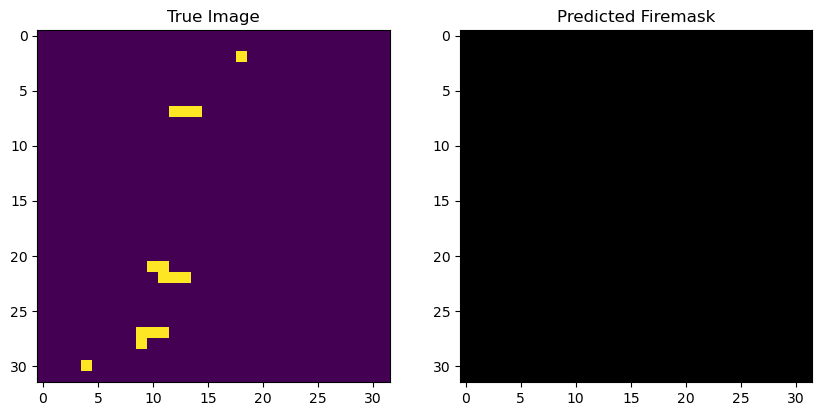

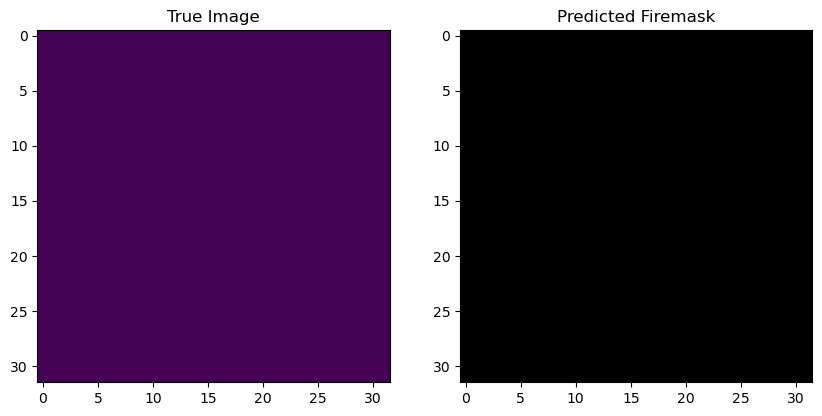

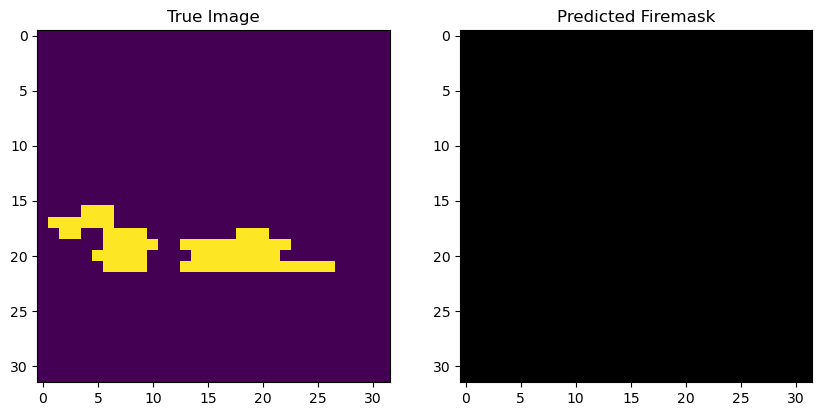

In [253]:
# threshold = 0.5  # Adjust the threshold depending on your task

# predicted_masks = (predictions_tensor > threshold).astype(np.uint8)  # Convert to binary mask

# 3. Visualize the predictions (optional)
# Let's display a few images and their corresponding masks
for i in range(10):  # Show 5 examples
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    # Display original image
    ax[0].imshow(test_labels_filtered[i])
    ax[0].set_title('True Image')
    
    # Display the predicted mask
    ax[1].imshow(predictions_tensor[i], cmap='gray')  # Using 'gray' colormap for binary masks
    ax[1].set_title('Predicted Firemask')
    
    plt.show()


In [331]:
model.summary()


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 32, 32, 64)        6976      
                                                                 
 max_pooling2d_39 (MaxPooli  (None, 16, 16, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_53 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 8, 8, 128)         0         
 ng2D)                                                           
                                                                 
 conv2d_54 (Conv2D)          (None, 8, 8, 256)         295168    
                                                                 
 max_pooling2d_41 (MaxPooli  (None, 4, 4, 256)       

In [192]:
def ResBlock(input_tensor, filters, dropout=0.1, batch_norm=False, l1=0.0, l2=0.0):
    x = Conv2D(filters, kernel_size=3, padding="same", 
                      kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2))(input_tensor)
    
    if batch_norm:
        x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(dropout)(x)

    x = Conv2D(filters, kernel_size=3, padding="same", 
                      kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2))(x)
    if batch_norm:
        x = BatchNormalization()(x)

    shortcut = Conv2D(filters, kernel_size=1, padding="same")(input_tensor)
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

# Encoder Block
def encoder(input_tensor, layers_list, pool_list, dropout=0.1, batch_norm=False, l1=0.0, l2=0.0):
    net = input_tensor
    for i, filters in enumerate(layers_list):
        net = ResBlock(net, filters, dropout=dropout, batch_norm=batch_norm, l1=l1, l2=l2)
        if i < len(pool_list):  # Apply pooling unless it's the last layer
            net = MaxPooling2D(pool_list[i])(net)
    return net

# Decoder Block
def decoder(input_tensor, layers_list, strides_list, dropout=0.1, batch_norm=False, l1=0.0, l2=0.0):
    net = input_tensor
    for i, filters in enumerate(layers_list):
        net = Conv2DTranspose(filters, kernel_size=3, strides=strides_list[i], 
                                     padding="same", 
                                     kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2))(net)
        if batch_norm:
            net = BatchNormalization()(net)
        net = ReLU()(net)
        net = ResBlock(net, filters, dropout=dropout, batch_norm=batch_norm, l1=l1, l2=l2)
    return net

# Segmentation Model
def create_segmentation_model(input_shape=(32, 32, 12), num_classes=1):
    inputs = Input(shape=input_shape)
    
    # Encoder
    encoder_layers = [16, 32, 64]  # Filters for each encoder layer
    pool_sizes = [(2, 2), (2, 2), (2, 2)]  # Pooling sizes
    x = encoder(inputs, encoder_layers, pool_sizes, dropout=0.1, batch_norm=True, l1=0.1, l2=0.1)

    # Bottleneck
    x = ResBlock(x, 128, dropout=0.1, batch_norm=True, l1=0.1, l2=0.1)

    # Decoder
    decoder_layers = [64, 32, 16]  # Filters for each decoder layer
    strides = [(2, 2), (2, 2), (2, 2)]  # Strides for upsampling
    x = decoder(x, decoder_layers, strides, dropout=0.1, batch_norm=True, l1=0.1, l2=0.1)

    # Output Layer
    outputs = Conv2D(num_classes, kernel_size=1, activation="sigmoid")(x)

    # Model creation
    model = Model(inputs, outputs)
    return model

# Instantiate and summarize the model
resblock_model = create_segmentation_model()
# resblock_model.summary()

In [206]:
def weighted_cross_entropy_with_logits_with_masked_class(
    pos_weight = 1.0):
  """Wrapper function for masked weighted cross-entropy with logits.

  This loss function ignores the classes with negative class id.

  Args:
    pos_weight: A coefficient to use on the positive examples.

  Returns:
    A weighted cross-entropy with logits loss function that ignores classes
    with negative class id.
  """

  def masked_weighted_cross_entropy_with_logits(y_true,
                                                logits):
    mask = tf.cast(tf.not_equal(y_true, -1), tf.float32)
    loss = tf.math.reduce_mean(mask * tf.nn.weighted_cross_entropy_with_logits(
        labels=y_true, logits=logits, pos_weight=pos_weight))
    return loss

  return masked_weighted_cross_entropy_with_logits

In [194]:
class AUCWithMaskedClass(tf.keras.metrics.AUC):
  """Computes AUC while ignoring class with id equal to `-1`.

  Assumes binary `{0, 1}` classes with a masked `{-1}` class.
  """

  def __init__(self, with_logits = False, **kwargs):
    super(AUCWithMaskedClass, self).__init__(**kwargs)
    self.with_logits = with_logits

  @tf.autograph.experimental.do_not_convert
  def update_state(self,
                   y_true,
                   y_pred,
                   sample_weight = None):
    """Accumulates metric statistics.

    `y_true` and `y_pred` should have the same shape.

    Args:
      y_true: Ground truth values.
      y_pred: Predicted values.
      sample_weight: Input value is ignored. Parameter present to match
        signature with parent class where mask `{-1}` is the sample weight.
    Returns: `None`
    """
    if self.with_logits:
      y_pred = tf.math.sigmoid(y_pred)
    mask = tf.cast(tf.not_equal(y_true, -1), tf.float32)
    super(AUCWithMaskedClass, self).update_state(
        y_true, y_pred, sample_weight=mask)

In [ ]:
fire_weights = [1.0, 2.0, 3.0, 4.0, 5.0]  # Range of fire weights to explore
results = []

for fire_weight in fire_weights:
    print(f"Training with fire weight: {fire_weight}")
    
    resblock_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=weighted_cross_entropy_with_logits_with_masked_class(pos_weight=fire_weight),
        metrics=[AUCWithMaskedClass()]
    )
    
    history = resblock_model.fit(
        train_data,
        validation_data=(eval_data),
        epochs=10,
        batch_size=32,
        verbose=1
    )
    
    results.append({
        "fire_weight": fire_weight,
        "train_auc": max(history.history.get('auc', [0])),  # Track training AUC
        "val_auc": max(history.history.get('val_auc', [0]))  # Track validation AUC
    })

for result in results:
    print(f"Fire Weight: {result['fire_weight']}, Train AUC: {result['train_auc']}, Val AUC: {result['val_auc']}")

In [207]:
resblock_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=weighted_cross_entropy_with_logits_with_masked_class(3.0),
        metrics=[tf.keras.metrics.AUC(curve='PR')]
    )

In [208]:
history = resblock_model.fit(
    train_data_filtered,
    validation_data=eval_data_filtered,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint("best_resblock_model.h5", save_best_only=True)
    ]
)

Epoch 1/10
108/108 [==============================] - 19s 75ms/step - loss: 1440.3289 - auc_17: 0.0268 - val_loss: 1191.5394 - val_auc_17: 0.0323
Epoch 2/10
  1/108 [..............................] - ETA: 2s - loss: 1191.5532 - auc_17: 0.0227

/opt/conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


108/108 [==============================] - 3s 28ms/step - loss: 981.7781 - auc_17: 0.0269 - val_loss: 784.3967 - val_auc_17: 0.0333
Epoch 3/10
108/108 [==============================] - 3s 28ms/step - loss: 623.5798 - auc_17: 0.0271 - val_loss: 475.5078 - val_auc_17: 0.0331
Epoch 4/10
108/108 [==============================] - 3s 28ms/step - loss: 361.5728 - auc_17: 0.0274 - val_loss: 260.6423 - val_auc_17: 0.0326
Epoch 5/10
108/108 [==============================] - 3s 28ms/step - loss: 191.2174 - auc_17: 0.0275 - val_loss: 134.5520 - val_auc_17: 0.0325
Epoch 6/10
108/108 [==============================] - 3s 28ms/step - loss: 99.7092 - auc_17: 0.0274 - val_loss: 71.5739 - val_auc_17: 0.0327
Epoch 7/10
108/108 [==============================] - 3s 28ms/step - loss: 53.5677 - auc_17: 0.0271 - val_loss: 39.4326 - val_auc_17: 0.0328
Epoch 8/10
108/108 [==============================] - 3s 28ms/step - loss: 30.4357 - auc_17: 0.0271 - val_loss: 22.8639 - val_auc_17: 0.0334
Epoch 9/10
108/1

In [209]:
# Evaluate on test data
test_loss, test_auc = resblock_model.evaluate(test_data_filtered)
print(f"Test Loss: {test_loss}, Test AUC: {test_auc}")

12/12 [==============================] - 1s 111ms/step - loss: 7.5075 - auc_17: 0.0269
Test Loss: 7.5074663162231445, Test AUC: 0.026892872527241707


In [210]:
resblock_preds = resblock_model.predict(test_data_filtered)

12/12 [==============================] - 0s 6ms/step


In [211]:
resblock_preds.shape

(1176, 32, 32, 1)